In [1]:
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import pandas as pd
import re 
from matplotlib import pyplot
import seaborn as sns
import numpy as np
import os
from textblob import TextBlob
import datetime
from matplotlib import pyplot as plt


Using TensorFlow backend.


In [2]:
timeseries_test = pd.read_csv('../Data/Output/timeseries_merged.csv',encoding='latin1')
timeseries_test.set_index('Date', inplace=True)
timeseries_test['difficulty'] = timeseries_test['difficulty'].apply(lambda x: '{:.2f}'.format(x))

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [23]:

#x_cols = list(timeseries_test.columns)
#x_cols.remove('close')
#y_col=['close']

In [24]:
#x_values = timeseries_test[x_cols].values
#y_values = timeseries_test[y_col].values


In [25]:
#scaled_merged = concatenate((y_values,x_values), axis=1)

In [7]:
#approach 2 not req
#reframed = series_to_supervised(scaled_merged, 1, 1)
#reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var26(t),var27(t),var28(t),var29(t),var30(t),var31(t),var32(t),var33(t),var34(t),var35(t)
1,458.55,0.72804,66022.7,1.38597,8.3607,178678000000.00,1.10486e+08,240501,1.17244e+06,1.5313e+06,...,0.671409,8.01667,3.6871e+07,17998.1,7,8,10,3,26,23
2,461.43,0.874485,66133.7,0.88846,6.86161,178678000000.00,1.68026e+08,362233,1.12803e+06,1.49284e+06,...,0.904975,9.5,3.69319e+07,16768.8,14,14,4,5,10,12
3,466.09,0.81318,66256.5,1.12996,7.67591,178678000000.00,1.70332e+08,363973,1.3412e+06,1.92469e+06,...,0.977362,13.3,3.70225e+07,16423.2,8,4,6,1,18,7
4,444.69,0.875343,66369.4,0.873767,6.11106,178678000000.00,1.67459e+08,374369,1.1458e+06,1.4632e+06,...,0.803247,11.25,3.70775e+07,18568.4,12,7,5,3,12,16
5,449.01,0.898219,66491.6,0.904082,6.26113,178666000000.00,1.71721e+08,381602,1.20784e+06,1.5525e+06,...,0.750259,7.95,3.71843e+07,34366.9,9,8,3,1,9,10


In [118]:
values = timeseries_test.values
n_train_hours = 900
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(900, 35)

In [119]:
n_hours = 1 
n_features = 35 
n_obs = n_hours*n_features

In [120]:
# split into input and outputs
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]

In [121]:
test_X.shape

(51, 34)

In [122]:
x_train_scaler = MinMaxScaler(feature_range=(-1, 1))
y_train_scaler = MinMaxScaler(feature_range=(-1, 1))

x_test_scaler = MinMaxScaler(feature_range=(-1, 1))
y_test_scaler = MinMaxScaler(feature_range=(-1, 1))


In [123]:
train_X = x_train_scaler.fit_transform(train_X)
test_X = x_test_scaler.fit_transform(test_X)


c:\users\rupadhyay\python 3.6\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\rupadhyay\python 3.6\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [124]:
shape_train_y = train_y.reshape(-1, 1)

In [125]:
train_y = y_train_scaler.fit_transform(shape_train_y)

c:\users\rupadhyay\python 3.6\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [126]:
train_y = train_y[:, 0]  # Reshape and convert to 1D array

In [127]:
shape_test_y = test_y.reshape(-1, 1)
test_y = y_test_scaler.fit_transform(shape_test_y)
test_y = test_y[:, 0]

c:\users\rupadhyay\python 3.6\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [128]:
train_X.shape

(900, 34)

In [129]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, 34))
test_X = test_X.reshape((test_X.shape[0], n_hours, 34))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(900, 1, 34) (900,) (51, 1, 34) (51,)


In [135]:
# design network
model = Sequential()
model.add(LSTM(34, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=2, validation_data=(test_X, test_y), verbose=2, shuffle=False,validation_split=0.1)


Train on 900 samples, validate on 51 samples
Epoch 1/200
 - 3s - loss: 0.0886 - val_loss: 0.9961
Epoch 2/200
 - 1s - loss: 0.0741 - val_loss: 0.9953
Epoch 3/200
 - 1s - loss: 0.0592 - val_loss: 0.9972
Epoch 4/200
 - 1s - loss: 0.0525 - val_loss: 0.9891
Epoch 5/200
 - 1s - loss: 0.0448 - val_loss: 0.9763
Epoch 6/200
 - 1s - loss: 0.0434 - val_loss: 0.9723
Epoch 7/200
 - 1s - loss: 0.0447 - val_loss: 0.9560
Epoch 8/200
 - 1s - loss: 0.0415 - val_loss: 0.8989
Epoch 9/200
 - 1s - loss: 0.0395 - val_loss: 0.8623
Epoch 10/200
 - 1s - loss: 0.0392 - val_loss: 0.8172
Epoch 11/200
 - 1s - loss: 0.0386 - val_loss: 0.7964
Epoch 12/200
 - 1s - loss: 0.0395 - val_loss: 0.7799
Epoch 13/200
 - 1s - loss: 0.0366 - val_loss: 0.7551
Epoch 14/200
 - 1s - loss: 0.0403 - val_loss: 0.7551
Epoch 15/200
 - 1s - loss: 0.0416 - val_loss: 0.7103
Epoch 16/200
 - 1s - loss: 0.0389 - val_loss: 0.7041
Epoch 17/200
 - 1s - loss: 0.0396 - val_loss: 0.6849
Epoch 18/200
 - 1s - loss: 0.0384 - val_loss: 0.7298
Epoch 19/2

Epoch 154/200
 - 1s - loss: 0.0154 - val_loss: 0.3684
Epoch 155/200
 - 1s - loss: 0.0141 - val_loss: 0.3712
Epoch 156/200
 - 1s - loss: 0.0163 - val_loss: 0.3713
Epoch 157/200
 - 1s - loss: 0.0160 - val_loss: 0.3488
Epoch 158/200
 - 1s - loss: 0.0169 - val_loss: 0.3295
Epoch 159/200
 - 1s - loss: 0.0158 - val_loss: 0.3425
Epoch 160/200
 - 1s - loss: 0.0163 - val_loss: 0.3835
Epoch 161/200
 - 1s - loss: 0.0173 - val_loss: 0.3757
Epoch 162/200
 - 1s - loss: 0.0167 - val_loss: 0.3617
Epoch 163/200
 - 1s - loss: 0.0166 - val_loss: 0.3570
Epoch 164/200
 - 1s - loss: 0.0162 - val_loss: 0.3526
Epoch 165/200
 - 1s - loss: 0.0156 - val_loss: 0.3425
Epoch 166/200
 - 1s - loss: 0.0172 - val_loss: 0.3173
Epoch 167/200
 - 1s - loss: 0.0172 - val_loss: 0.3230
Epoch 168/200
 - 2s - loss: 0.0156 - val_loss: 0.3415
Epoch 169/200
 - 1s - loss: 0.0184 - val_loss: 0.3596
Epoch 170/200
 - 1s - loss: 0.0163 - val_loss: 0.3592
Epoch 171/200
 - 1s - loss: 0.0157 - val_loss: 0.3591
Epoch 172/200
 - 1s - loss: 

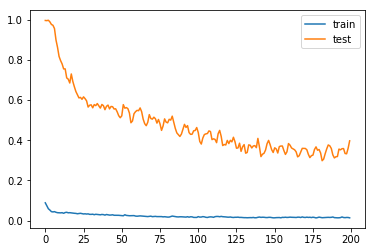

In [136]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features,))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -34:]), axis=1)
x_scaler.fit(inv_yhat)
inv_yhat = x_scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_scaler.fit(test_y)

inv_y = concatenate((test_y, test_X[:, -34:]), axis=1)
inv_y = y_scaler.inverse_transform(inv_y)

#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = (mean_squared_error(inv_y, inv_yhat))
print('Test MSE: %.3f' % mse)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [137]:
yhat = model.predict(test_X)

In [138]:
rmse = sqrt(mean_squared_error(test_y, yhat))

In [139]:
rmse 
# 0.7230 for 100 epochs
# 0.530 for 200 epochs
# 0.70 for 300 epochs
#0.49 for 200 epochs and batch size 2

0.45481024775282775

In [90]:
yhat = y_test_scaler.inverse_transform(yhat)

In [91]:
yhat  ####SUCCESS

array([[6076.2466],
       [6075.5083],
       [5095.597 ],
       [5139.1636],
       [5820.267 ],
       [6259.1367],
       [6346.3237],
       [6125.364 ],
       [6268.4175],
       [5734.474 ],
       [5368.2974],
       [6085.867 ],
       [6133.079 ],
       [5000.772 ],
       [5981.7144],
       [6152.7417],
       [5316.1133],
       [5132.5503],
       [6068.2144],
       [5895.0054],
       [5901.786 ],
       [5722.489 ],
       [5945.81  ],
       [5781.0366],
       [5481.015 ],
       [5934.6343],
       [5852.7417],
       [5847.775 ],
       [5796.9297],
       [5704.155 ],
       [5304.4634],
       [5310.2188],
       [5764.1475],
       [5482.1187],
       [5316.014 ],
       [4774.8193],
       [5193.057 ],
       [4873.108 ],
       [4717.9194],
       [4907.2617],
       [4774.053 ],
       [4505.505 ],
       [4575.431 ],
       [4494.3955],
       [4508.1978],
       [4783.824 ],
       [4750.608 ],
       [4395.0186],
       [4713.494 ],
       [4781.774 ],


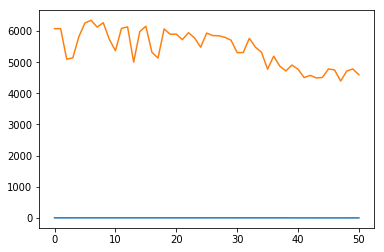

In [92]:
plt.plot(test_y, label='Real')
plt.plot(yhat, label='Predicted')

# PREDICT

In [140]:
test_predict = pd.read_csv('../Data/Output/test_timeseries_merged.csv',encoding='latin1')

In [141]:
test_predict.set_index('Date', inplace=True)

In [142]:
test_predict.head(5)

,avg_block_size,blocks_size,cost_per_transaction_percent,cost_per_transaction,difficulty,est_transaction_volume_USD,est_transaction_volume,hash_rate,miners_revenue,n_unique_addresses,...,transactions_per_sec_stddev,transactions_per_sec_max,utxo_count_mean,utxo_count_stddev,news_stories_positive,news_stories_negative,news_stories_neutral,Negative_Tweets,Neutral_Tweets,Positive_Tweets
Date,,,,,,,,,,,,,,,,,,,,,
12/1/2018,1.068438,192924.029808,0.923090,26.914157,6.653303e+12,7.051436e+08,171285.334800,41011449.14,6509108.18,420224.0,...,1.323969,20.683333,58380899.25,12711.208037,297.0,508.0,110.0,31.0,64.0,75.0
12/2/2018,1.005272,193038.630789,1.715932,27.105352,6.653303e+12,3.517405e+08,84399.905117,37704074.21,6035630.09,364378.0,...,1.147508,24.466667,58397569.04,12797.050623,287.0,497.0,95.0,27.0,95.0,97.0
12/3/2018,1.101028,193164.148009,0.455677,24.006523,6.194016e+12,1.267830e+09,319552.043684,31998005.40,5777217.67,426799.0,...,1.059332,26.566667,58430813.58,9615.069463,386.0,552.0,181.0,27.0,122.0,96.0
12/4/2018,1.083460,193313.665436,0.279035,25.753689,5.646404e+12,2.493726e+09,629491.330519,38734427.59,6958363.40,492964.0,...,1.054051,26.100000,58453246.33,9025.975571,383.0,541.0,188.0,29.0,80.0,103.0
12/5/2018,1.036768,193448.445287,0.442812,24.839415,5.646404e+12,1.438836e+09,372914.991753,36488953.53,6371334.81,438437.0,...,0.990134,26.050000,58496345.79,9608.661188,359.0,532.0,149.0,50.0,105.0,118.0


In [143]:
test_predict['difficulty'] = test_predict['difficulty'].apply(lambda x: '{:.2f}'.format(x))

In [144]:
test_predict['est_transaction_volume_USD'] = test_predict['est_transaction_volume_USD'].apply(lambda x: '{:.2f}'.format(x))

In [145]:
pred_values = test_predict.values

In [146]:
pred_values.shape

(113, 34)

In [147]:
p_x_test_scaler = MinMaxScaler(feature_range=(-1, 1))

In [148]:
test_X = p_x_test_scaler.fit_transform(pred_values)

c:\users\rupadhyay\python 3.6\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [149]:
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], 1, 34))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(900, 1, 34) (900,) (113, 1, 34) (51,)


In [150]:
p_yhat = model.predict(test_X)

In [151]:
p_yhat = y_test_scaler.inverse_transform(p_yhat)

In [152]:
p_yhat

array([[5785.7676],
       [5353.846 ],
       [5372.9277],
       [4911.813 ],
       [4787.7817],
       [4489.7397],
       [4487.871 ],
       [4027.4297],
       [4089.0842],
       [4214.1255],
       [4235.948 ],
       [4229.1226],
       [4473.003 ],
       [4271.3584],
       [3950.7415],
       [3953.3528],
       [4143.3228],
       [4779.7485],
       [5309.651 ],
       [5192.1333],
       [5557.616 ],
       [5832.028 ],
       [5586.8267],
       [5713.4067],
       [4743.2583],
       [4750.0254],
       [5263.397 ],
       [5148.3076],
       [5025.294 ],
       [5215.039 ],
       [4848.8354],
       [4614.2935],
       [5010.1245],
       [5219.8037],
       [4954.575 ],
       [5016.5366],
       [4754.5874],
       [5199.75  ],
       [5459.852 ],
       [5425.1694],
       [4766.594 ],
       [4391.2026],
       [4087.5093],
       [4084.5117],
       [4205.2036],
       [4369.406 ],
       [4337.8174],
       [4240.4253],
       [4317.5684],
       [4212.4785],


In [108]:
p_yhat.shape

(113, 1)

In [153]:
df_p_yhat = pd.DataFrame(p_yhat, index=p_yhat[:,0], columns=['close'])

In [154]:
df_p_yhat.to_csv('../Data/Output/predicted_values.csv')

In [155]:
submission_df = pd.read_csv('../Data/Output/Submission_The_Machinists.csv',encoding='latin1')

In [156]:
submission_df.head()

,date,close
0,12/1/2018,5785.7676
1,12/2/2018,5353.8460
2,12/3/2018,5372.9277
3,12/4/2018,4911.8130
4,12/5/2018,4787.7817


In [157]:
submission_df['date'] = submission_df.date.apply(lambda x:datetime.datetime.strptime(x, "%m/%d/%Y").strftime("%Y-%m-%d"))

In [158]:
submission_df.head()

,date,close
0,2018-12-01,5785.7676
1,2018-12-02,5353.8460
2,2018-12-03,5372.9277
3,2018-12-04,4911.8130
4,2018-12-05,4787.7817


In [159]:
submission_df.to_csv('../Data/Output/Submission_The_Machinists_1.csv')